## Efficient Data Stream Anomaly Detection

### 1. Data Stream Simulation
a. **generate_data_stream** - This function, generate_data_stream, generates a synthetic time-series data stream with a sinusoidal pattern based on the specified pattern_length. It checks if pattern_length is a positive integer; if not, it raises a ValueError. The sinusoidal pattern is defined by a dynamic amplitude (A), a center value with random drift, a slightly varied phase angle (phi), and a period with minor randomness. Gaussian noise is added to simulate measurement inaccuracies, and the function returns the generated data stream.

b. **add_anomalies_to_data** - This function, add_anomalies_to_data, introduces anomalies into an existing data stream by modifying values at randomly selected indices. It accepts a data_stream argument, which must be a NumPy array; if not, it raises a TypeError. The function randomly selects a specified number of indices to introduce anomalies.

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data_stream(pattern_length):
    try:
        # Check if pattern_length is a positive integer
        if not isinstance(pattern_length, int) or pattern_length <= 0:
            raise ValueError("Pattern length must be a positive integer.")

        # Set the pattern length
        n = pattern_length
        # Set amplitude with some variability
        A = 50 + np.random.uniform(-10, 10, n)
        # Set center value with a small random drift
        center = 100 + np.random.normal(0, 2, n)
        # Set phase angle with slight variation
        phi = 30 + np.random.uniform(-2, 2)
        # Set period with slight randomness
        T = (2 * np.pi / 100) + np.random.uniform(-0.001, 0.001)
        # Generate time values
        t = np.arange(n)
        # Generate a sinusoidal pattern with noise and randomness
        sin = A * np.sin(T * t - phi * T) + center
        # Add some Gaussian noise to simulate measurement noise
        noise = np.random.normal(0, 1, n)
        data_stream = sin + noise

        return data_stream

    except ValueError as e:
        print(f"Error in generate_data_stream: {e}")


def add_anomalies_to_data(data_stream, num_anomalies=10):
    try:
        # Check if data_stream is a NumPy array
        if not isinstance(data_stream, np.ndarray):
            raise TypeError("Data stream must be a NumPy array.")

        # Randomly select indices to introduce anomalies
        anomaly_indices = np.random.choice(len(data_stream), size=num_anomalies, replace=False)
        
        # Introduce different types of anomalies:
        for idx in anomaly_indices:
            # Either set a large spike or a sharp drop
            if np.random.rand() > 0.5:
                data_stream[idx] += np.random.uniform(50, 100)  # spike
            else:
                data_stream[idx] -= np.random.uniform(50, 100)  # drop

        return data_stream

    except TypeError as e:
        print(f"Error in add_anomalies_to_data: {e}")


In [8]:
print(data_stream)

[ 46.08630706  48.14460043  44.25007135 -20.30444834  41.62707313
  56.13463113  45.55531714  42.31189636  50.02787451  53.26906326
  57.30756464  61.57817606  51.95964143  54.22182055  60.50282525
  64.44388831  62.12251573  67.22015257  68.58058094  67.89642509
  71.04885942  78.79716609  79.85521597  81.43361541  84.98819047
  87.42912736  93.38884627  89.68436389  99.73669337 100.05735487
 102.71528469 105.1023824  111.91294041 115.18517693 116.78745663
 122.6146477  121.00862423 124.71464448 131.11272204 126.97399064
 136.29829902 132.42768319 136.8135084  147.12378668 137.98576362
 148.86235554 138.47598725 147.30444708 153.9711259  153.07566542
 143.51345976 148.13002273 139.07745765 152.59033062 159.72446034
 159.68837447 146.5441111  140.50457037 146.06170054 143.03283126
 137.87003165 148.6551493  149.52014441 146.25754131 145.32509972
 137.71680605 134.74333045 132.05794604 132.65184218 123.42720981
 129.21484112 127.12948215 121.9889561  116.6989856  109.29103365
 107.70739

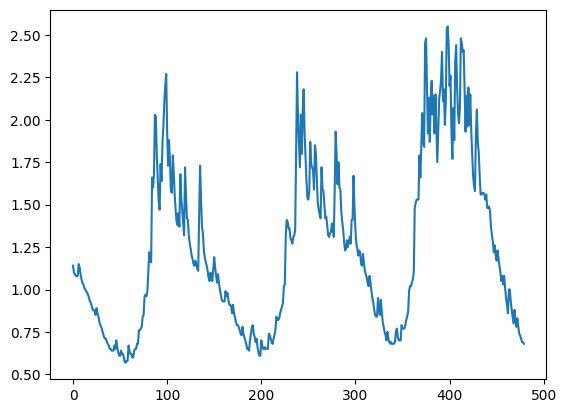

In [45]:


# Plot the data stream using Matplotlib
plt.plot(np.arange(480), data_stream)

# Display the plot
plt.show()

### 2. Algorithm Selection
For this project, I have selected the **Robust Random Cut Forest (RCF)** algorithm to detect anomalies.

The RCF algorithm, implemented here with a custom RCTreeForest class, is designed for *detecting anomalies in sequential data*. RCF is particularly effective for streaming data due to its ability to handle evolving data patterns and detect anomalies in real-time. This is achieved by using a forest of random cut trees, where each tree is trained on a sliding window of the data stream, enabling the model to continuously adapt to new data. \
The process involves calculating a codisplacement score for each data point, representing its deviation from the typical pattern within the dataset. Anomalies are identified when this score significantly deviates from prior values, which helps highlight sudden changes or irregularities in the data. \

**Effectiveness**\
The effectiveness of the RCF algorithm is demonstrated by its flexibility and computational efficiency, which are essential for real-time anomaly detection. The average codisplacement threshold of 1.7 used in this implementation has shown good performance, capturing anomalies like spikes and drops in a simulated sinusoidal dataset with added noise. This makes RCF a reliable choice for applications where maintaining the integrity of data streams is critical.

### 3. Anomaly Detection
This code defines a Python class named RCTreeForest that implements an anomaly detection algorithm using a Random Cut Tree (RCT) forest. Below are the key components:

- **Class Initialization** \
The RCTreeForest class is initialized with three parameters: num_trees, tree_size, and window_size. These parameters define the characteristics of the RCT forest. The initialization process includes: \
Parameter Validation: The class checks if all input parameters are positive integers; otherwise, it raises a ValueError. \
Forest Creation: It initializes the number of trees, the size of each tree, and the shingle size for processing the data stream. A list of RCTree instances is created to form the RCT forest.

- **Anomaly Detection Method** \
The anomaly_detector method is responsible for detecting anomalies in the data stream. It takes two parameters: index and point. \
Key steps include:\
Input Validation: The method checks if index is a non-negative integer and if point is a list of numeric values with the correct length; otherwise, it raises a ValueError.\
Average Codisplacement Calculation: It initializes avg_codisplacement to zero, which accumulates the codisplacement values from each tree in the forest.
The method returns the average codisplacement for the given data point. An anomaly is identified if the average codisplacement is greater than or equal to 1.7 times the previous value, allowing for fine-tuning of the detection threshold.

In [4]:
pip install rrcf


  Using cached rrcf-0.4.4-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [34]:
import rrcf

class RCTreeForest:
    def __init__(self, num_trees, tree_size, window_size):
        try:
            # Check if input parameters are positive integers
            if not all(isinstance(param, int) and param > 0 for param in [num_trees, tree_size, window_size]):
                raise ValueError("All parameters must be positive integers.")

            # Initialize the Random Cut Tree (RCT) forest with a specified number of trees and tree size
            self.num_trees = num_trees
            self.tree_size = tree_size
            self.shingle_size = window_size

            # Create a list of RCTree instances to form the forest
            self.forest = [rrcf.RCTree() for _ in range(num_trees)]

        except ValueError as e:
            print(f"Error in initialization: {e}")

    def anomaly_detector(self, index, point):
        try:
            # Check if index is a positive integer
            if not isinstance(index, int) or index < 0:
                raise ValueError("Index must be a non-negative integer.")

            # Check if point is a list of numeric values with the correct length
            if not isinstance(point, list) or len(point) != self.shingle_size or not all(isinstance(p, (int, float)) for p in point):
                raise ValueError(f"Point must be a list of {self.shingle_size} numeric values.")

            # Initialize average codisplacement to zero
            avg_codisplacement = 0

            for tree in self.forest:
                # If the tree size exceeds the specified limit, forget the oldest point (FIFO)
                if len(tree.leaves) > self.tree_size:
                    tree.forget_point(index - self.tree_size)

                # Insert the new point into the tree
                tree.insert_point(point, index=index)

                # Compute the codisplacement for the new point
                new_codisplacement = tree.codisp(index)

                # Accumulate the codisplacement across all trees
                avg_codisplacement += new_codisplacement / self.num_trees

            # Return the average codisplacement for the given point
            return avg_codisplacement

        except ValueError as e:
            print(f"Error in anomaly detection: {e}")

In [35]:
# Define the number of trees in the Random Cut Tree (RCT) forest
num_trees = 40

# Define the size limit for each tree in the RCT forest
tree_size = 256

## Define the size of the window
shingle_size=4

# Create an instance of the RCTreeForest class with the specified number of trees and tree size
forest = RCTreeForest(num_trees, tree_size,shingle_size)

In [36]:
import pandas as pd
data_stream =pd.read_csv("cpu.csv",encoding='latin-1')

In [37]:
data_stream = data_stream['cpu']

In [43]:
data_stream =np.array(data_stream)
print(len(data_stream))

480


In [39]:
# Initialize empty lists to store anomaly scores and the current data window
anomaly_score = []
current_window = []
prev_idx=0
first=True

# Iterate through the data stream
for i in range(len(data_stream)):
    # If the index is within the shingle size, populate the initial window with data_stream values
    if i < forest.shingle_size:
        current_window.append(data_stream[i])
        # Initialize anomaly score to 0 for the initial window
        anomaly_score.append(0)
        continue
    else:
        # Update the current window by adding the latest data_stream value and removing the oldest
        current_window.append(data_stream[i])
        current_window = current_window[1:]
    
    # Calculate anomaly score using the RCT forest for the current window
    score = forest.anomaly_detector(i, current_window)
    
    # Print the index for tracking progress (optional)
    #print(i, end=' ')
    
    # Append the calculated anomaly score to the list
    anomaly_score.append(score)
    
    #If there is a sudden peak we can say it is a anomaly
    if i>forest.shingle_size+1 and (score>=1.7*anomaly_score[i-1] or score<=-1.7*anomaly_score[i-1] ): 
        print("Anomaly_Detected_at_index: ", i)

Anomaly_Detected_at_index:  48
Anomaly_Detected_at_index:  70
Anomaly_Detected_at_index:  80
Anomaly_Detected_at_index:  84
Anomaly_Detected_at_index:  134
Anomaly_Detected_at_index:  208
Anomaly_Detected_at_index:  216
Anomaly_Detected_at_index:  224
Anomaly_Detected_at_index:  237
Anomaly_Detected_at_index:  238
Anomaly_Detected_at_index:  244
Anomaly_Detected_at_index:  278
Anomaly_Detected_at_index:  324
Anomaly_Detected_at_index:  349
Anomaly_Detected_at_index:  363
Anomaly_Detected_at_index:  374
Anomaly_Detected_at_index:  375
Anomaly_Detected_at_index:  397
Anomaly_Detected_at_index:  406
Anomaly_Detected_at_index:  432
Anomaly_Detected_at_index:  445
Anomaly_Detected_at_index:  450
Anomaly_Detected_at_index:  457
Anomaly_Detected_at_index:  465


In [42]:
print("Anomaly_Scores: ", len( anomaly_score))



Anomaly_Scores:  480


###  4. Visualization
This code uses Matplotlib to visualize a data stream and its corresponding anomaly scores. It creates a plot with a specified size, where the original data stream is displayed alongside the anomaly scores highlighted in red. A legend differentiates the two lines, and the plot is rendered for analysis, helping to identify anomalies within the data stream.

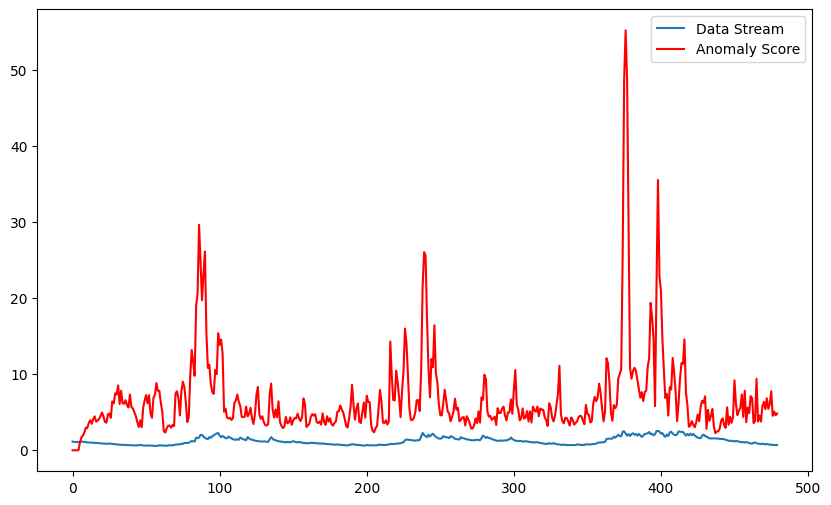

In [46]:
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed


# Plot the original data stream using Matplotlib
plt.plot(np.arange(480), data_stream, label='Data Stream')

# Plot the calculated anomaly scores using Matplotlib
plt.plot(np.arange(480), anomaly_score, label='Anomaly Score', color='red')

# Display the legend to distinguish between the two lines
plt.legend(loc='upper right')


# Display the plot
plt.show()